
# Information Conditions - Environmental State and Action Histories

> Plot learning trajectories under different information conditions of the Ecological Public Goods Game. a) Only environmental state history observable, b) only action history is observable, c) both environmental state and action histories are observable d) No information


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

from pyCRLD.Environments.SocialDilemma import SocialDilemma
from pyCRLD.Environments.EcologicalPublicGood import EcologicalPublicGood

from pyCRLD.Agents.StrategyActorCritic import stratAC
from pyCRLD.Agents.POStrategyActorCritic import POstratAC


from pyCRLD.Utils import FlowPlot as fp
from fastcore.utils import *
from jax import jit
import jax.numpy as jnp
from pyCRLD.Environments.HistoryEmbedding import HistoryEmbedded

from nbdev.showdoc import show_doc
from scipy.stats import kstest

from scipy.stats import qmc
import itertools as it
import pandas as pd

global_seed = 42
np.random.seed(global_seed)

In [18]:

ecopg = EcologicalPublicGood(N=2, f=1.2, c=5, m=-6, qc=0.02, qr= 0.0001, degraded_choice=True)
ecopg_with_history = HistoryEmbedded(ecopg, h = (1,1,1))

In [9]:

#average policy 

def average_policy_for_given_observation_set(X, O):
    """
    Takes in the strategy wrt to complete state set as input and returns the average strategy wrt to the given observation set. For example Strategty with respect to state set might
    have c, c, g = 0.2 and c, c, p = 0.8. But the observation set will be c, c, if only actions are observed. Then the average strategy for this observation set would be 0.5

    """
    A, S, F = X.shape        # Number of layers, states, and features
    _, _, num_obs = O.shape   # Number of observations

    # Initialize the output matrix with zeros
    output = np.zeros((A, num_obs, F))

    for i in range(A):
        for obs in range(num_obs):
            current_mask = O[i, :, obs]  # Shape: (S,)

            # Select rows from X where mask is 1
            selected_X = X[i][current_mask == 1]  # Shape: (num_selected_states, F)
            if selected_X.size > 0:
                mean_vector = selected_X.mean(axis=0)  # Shape: (F,)
            else:
                mean_vector = np.zeros(F)  # Default to zero vector
            output[i, obs, :] = mean_vector

    return output




In [10]:

#generate 
def generate_action_history_observation_set(stateset, number_of_agents):
    action_histories = [state[:3] for state in stateset]
    unique_action_histories = sorted(list(set(action_histories)))
    Oset = [unique_action_histories.copy() for _ in range(number_of_agents)]
    return Oset


def generate_state_observation_set(stateset, number_of_agents):
    state_histories = [state[4:] for state in stateset]
    unique_state_histories = sorted(list(set(state_histories)))
    Oset = [unique_state_histories.copy() for _ in range(number_of_agents)]
    return Oset



In [11]:

#information conditions class
class Information_Conditions(HistoryEmbedded):
    def __init__(self, ecopg , mode):


        super().__init__(ecopg, h=(1, 1, 1))

        self.mode = mode
        self.configure_information_condition()

    def configure_information_condition(self):
        """
        Set the observation mode and configure the observation tensor, Oset, and other properties.
        Modes: 'state', 'action', 'none', 'state+action'
        """
        if self.mode == "only_state_information":
            self._configure_state()
        elif self.mode == "only_action_history_information":
            self._configure_action()
        elif self.mode == "no_information":
            self._configure_none()
        elif self.mode == "both_state_and_action_information":
            self._configure_state_action()
        else:
            raise ValueError("Invalid mode..")
        # self._print_configuration()

        self.Q = self.O.shape[2]

    def _configure_state(self):
        def generate_state_tensor(state_set, observation_set):
            state_tensor = np.zeros((2, len(state_set), len(observation_set)), dtype=int)
            for i in range(2):
                for j, state in enumerate(state_set):
                    for k, observation in enumerate(observation_set):
                        if state.endswith(observation):
                            state_tensor[i, j, k] = 1
            return state_tensor
        
        
        self.Oset = generate_state_observation_set(self.Sset, 2)

        self.O = generate_state_tensor(
            self.Sset,  self.Oset[0])
        

    def _configure_action(self):
        def generate_action_tensor(state_set, action_set):
            action_tensor = np.zeros((2, len(state_set), len(action_set)), dtype=int)
            for i in range(2):  
                for j, state in enumerate(state_set):
                    for k, action in enumerate(action_set):
                        if action[:3] == state[:3]:
                            action_tensor[i, j, k] = 1
            return action_tensor

        self.Oset = generate_action_history_observation_set(self.Sset, self.N)
        self.O = generate_action_tensor(self.Sset, self.Oset[0])

    def _configure_none(self):
        def generate_none_tensor():
            return np.ones((2, 8, 1), dtype=int)

        self.O = generate_none_tensor()
        self.Oset = [['.'], ['.']]

    def _configure_state_action(self):
        # This assumes the default state+action information in `ecopg_with_history`
        pass
          # No modification needed; default setup already uses state+action information.


    def _print_configuration(self):
        print(f"Mode: {self.mode}")
        # print("Observation Tensor:\n", self.O)
        # print("Observation Set:", self.Oset)
        # print("O shape", self.O.shape)
        # print("Q shape", self.Q)

        print("------\n")


In [ ]:
mae = POstratAC(env= ecopg_with_history, learning_rates=0.1, discount_factors=0.9)
X_randome_ = [mae.random_softmax_strategy() for _ in range(5)]

#Just to initialise a random startegy for the state set. This will be used to get the average policy for the given observation set



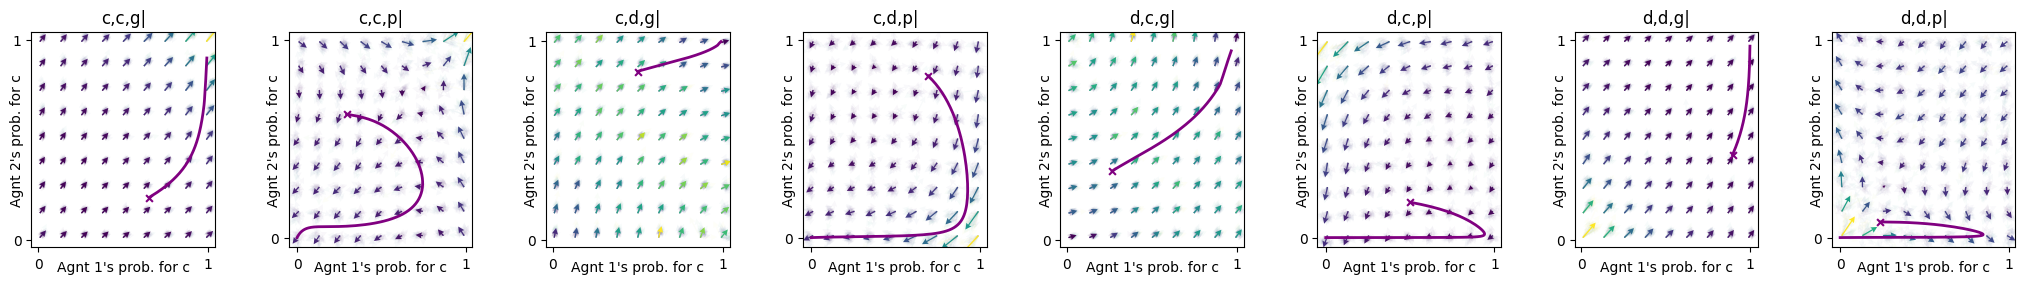

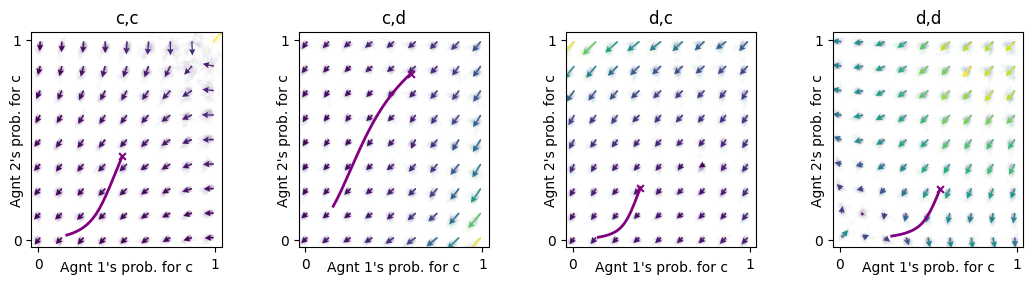

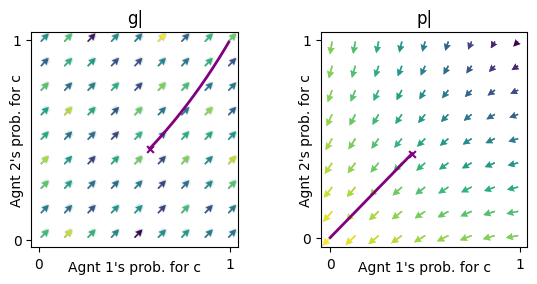

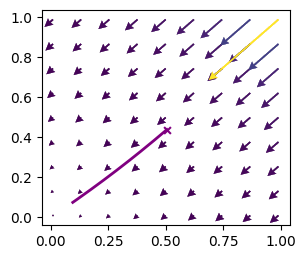

In [ ]:
#| export

for mode in ['both_state_and_action_information','only_action_history_information', 'only_state_information','no_information', ]:
    #for each information condition get the average policy for the given observation set and plot the flow diagram

    
    information_condition_instance = Information_Conditions(ecopg, mode=mode)
    num_observed_states = len(information_condition_instance.Oset[0])
    x, y = ([0], list(range(num_observed_states)), [0]), ([1], list(range(num_observed_states)), [0])
    mae1 = POstratAC(env=information_condition_instance, learning_rates=0.1, discount_factors=0.96)

    ax = fp.plot_strategy_flow(
        mae1,
        x, y, flowarrow_points=np.linspace(0.01, 0.99, 9), NrRandom=32,
        conds=np.array(information_condition_instance.Oset)[0, :num_observed_states]  # Adjust conditions for the mode
    )

    X_for_observation_set = average_policy_for_given_observation_set(X_for_state_set, information_condition_instance.O)
    xtraj, fixedpointreached = mae1.trajectory(X_for_observation_set, Tmax=10000, tolerance=1e-5)

    fp.plot_trajectories([xtraj], x, y, cols=['purple'], axes = ax)

    # plt.figure()
    # plt.plot(xtraj[:, 0, 0, 0], label="Agent 0", c='red')
    # plt.plot(xtraj[:, 1, 0, 0], label="Agent 1", c='blue')
    # plt.xlabel('Time steps')
    # plt.ylabel('Cooperation probability')
    # plt.legend()
    # plt.title(mode + " trajectory")



### Experiments and Observations 

array([<Axes: title={'center': 'c,c,g|'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">,
       <Axes: title={'center': 'c,c,p|'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">,
       <Axes: title={'center': 'c,d,g|'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">,
       <Axes: title={'center': 'c,d,p|'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">,
       <Axes: title={'center': 'd,c,g|'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">,
       <Axes: title={'center': 'd,c,p|'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">,
       <Axes: title={'center': 'd,d,g|'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">,
       <Axes: title={'center': 'd,d,p|'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">],
      dtype=object)

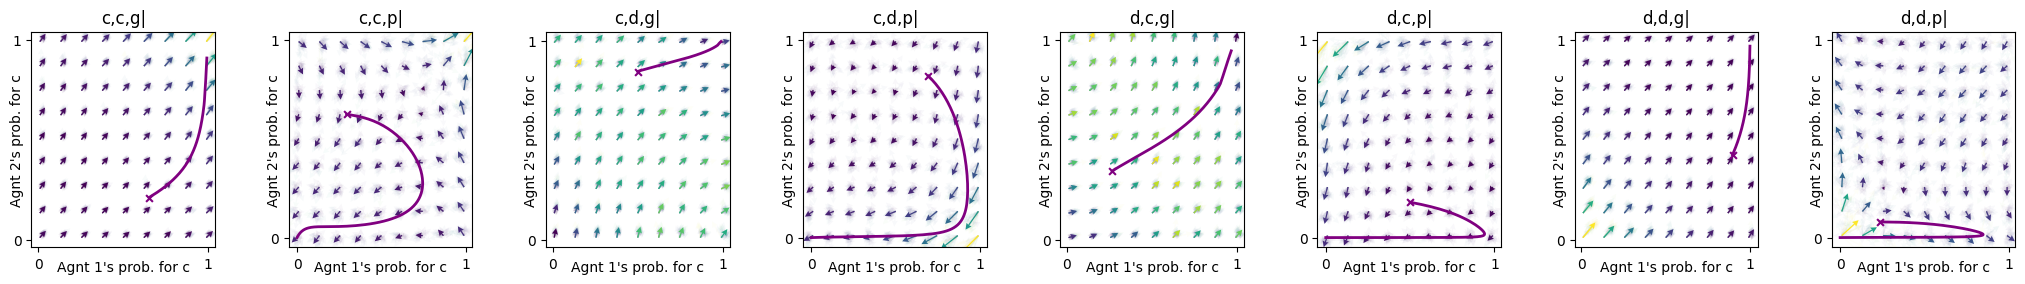

In [ ]:
#| export


information_condition_instance = Information_Conditions(ecopg, mode='both_state_and_action_information')
num_observed_states = len(information_condition_instance.Oset[0])
x, y = ([0], list(range(num_observed_states)), [0]), ([1], list(range(num_observed_states)), [0])
mae1 = POstratAC(env=information_condition_instance, learning_rates=0.1, discount_factors=0.96)

ax = fp.plot_strategy_flow(
    mae1,
    x, y, flowarrow_points=np.linspace(0.01, 0.99, 9), NrRandom=32,
    conds=np.array(information_condition_instance.Oset)[0, :num_observed_states]  # Adjust conditions for the mode
)

initial_conditions_list = lhs_sampling(mae.Q, 2, mae.N)

for initial_condition in initial_conditions_list:
    xtraj, fixedpointreached = mae1.trajectory(X_for_observation_set, Tmax=10000, tolerance=1e-5)
    fp.plot_trajectories([xtraj], x, y, cols=['black'], axes = ax)

    # plt.figure()
    # plt.plot(xtraj[:, 0, 0, 0], label="Agent 0", c='red')
    # plt.plot(xtraj[:, 1, 0, 0], label="Agent 1", c='blue')
    # plt.xlabel('Time steps')
    # plt.ylabel('Cooperation probability')
    # plt.legend()
    # plt.title(mode + " trajectory")

